In this notebook, I perform Ramsey fringe experiment to precisely measure $\omega_{12}$

### References

[1]: M. J. Peterer *et al.* Coherence and Decay of Higher Energy Levels of a Superconducting Transmon Qubit. *Phys. Rev. Lett.* **114***, 010501 (2015). [https://doi.org/10.1103/PhysRevLett.114.010501](https://doi.org/10.1103/PhysRevLett.114.010501).

In [1]:
import os
os.chdir('/Users/ngdnhtien/Research/Codespace/PulsatingPulseShop/')

# Necessary dependencies

# qiskit
import qiskit
import qiskit_ibm_provider

# qutritium
import utility as ut
import constant

# numerical
import numpy as np
import pickle 
import matplotlib.pyplot as plt

plt.rcParams['axes.linewidth'] = 1
%config InlineBackend.figure_formats = ['svg']

In [3]:
provider = qiskit_ibm_provider.IBMProvider()
backend = provider.get_backend('ibm_brisbane')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()
dt = backend_config.dt

qubit = 109
cbit = 0
num_qubits = int(qubit+1)
num_cbits = 1
weight = 1

In [64]:
rough_01_freq = backend_defaults.qubit_freq_est[qubit]
qubit_anharmonicty = backend_properties.qubits[qubit][3].value* constant.GHz
rough_12_freq = rough_01_freq + qubit_anharmonicty

print(r"f01 = "+f'{round(rough_01_freq/constant.GHz, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/constant.GHz, 4)}'+' GHz')

f01 = 4.985 GHz
f12 = 4.6779 GHz


In [66]:
amp_x12 = 0.31629007
amp_sx12 = amp_x12/2
beta_x12 = -0.45482766512256806
beta_sx12 = -0.5445620221293682

In [67]:
with qiskit.pulse.build(backend=backend) as sched_sx12:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
    qiskit.pulse.play(qiskit.pulse.Drag(duration=64, amp=amp_sx12, sigma=16, beta=beta_sx12), drive_chan)
    
gate_sx12 = qiskit.circuit.Gate('SX12', weight, [])

ground_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
ground_circ.measure(qubit, cbit)

first_excited_state_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
first_excited_state_circ.x(qubit)
first_excited_state_circ.measure(qubit, cbit)

second_excited_state_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
second_excited_state_circ.x(qubit)
second_excited_state_circ.append(gate_sx12, [qubit])
second_excited_state_circ.append(gate_sx12, [qubit])
second_excited_state_circ.measure(qubit, cbit)
second_excited_state_circ.add_calibration(gate_sx12, [qubit], sched_sx12)

new_discrim = [ground_circ, first_excited_state_circ, second_excited_state_circ]

In [68]:
reset_circuit = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
reset_circuit.measure(qubit, cbit)

reset_circuits = [reset_circuit, reset_circuit]

# Precise measurement of $\omega_{12}/2\pi$

In [55]:
with qiskit.pulse.build(backend) as x90_pulse:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.play(qiskit.pulse.Drag(duration=64,
                              amp=amp_sx12,
                              sigma=16, 
                              beta=beta_sx12), drive_chan)

In [56]:
delay_time_dt = np.arange(128, 8000, 16)

In [57]:
detuning_MHz = 2 
ramsey_frequency = round(rough_12_freq + detuning_MHz * constant.MHz, 6)

In [58]:
delay = qiskit.circuit.Parameter('delay')

with qiskit.pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    qiskit.pulse.set_frequency(ramsey_frequency, drive_chan)
    qiskit.pulse.call(x90_pulse)
    qiskit.pulse.delay(delay, drive_chan)
    qiskit.pulse.call(x90_pulse)

In [63]:
ramsey_gate = qiskit.circuit.Gate("ramsey", 1, [delay])

qc_ramsey = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
qc_ramsey.x(qubit)
qc_ramsey.append(ramsey_gate, [qubit])
qc_ramsey.measure(qubit, cbit)
qc_ramsey.add_calibration(ramsey_gate, [qubit], ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: d}, inplace=False) for d in delay_time_dt]

In [70]:
ramseyv0_package = []

ramseyv0_package = new_discrim + exp_ramsey_circs + reset_circuits
ramseyv0_job = backend.run(ramseyv0_package, meas_level=1, meas_return='single', shots=2048)

ramseyv0_job.job_id()

'crgenq6ytv7g0081fqg0'

In [71]:
ramseyv0_job = provider.backend.retrieve_job('crgenq6ytv7g0081fqg0')

ramseyv0_exp = ut.DataAnalysis(experiment=ramseyv0_job, average=False, shots=2048, qubit=0)
ramseyv0_exp.retrieve_data(average=False)
ramseyv0_exp.build_discrim()
ramseyv0_exp.count_pop()
ramseyv0_exp.error_mitiq()

In [73]:
pop2_ramseyv0 = ramseyv0_exp.mitiq_data[3:-2][:, 2]

In [82]:
delay_time_sec = delay_time_dt * dt

(0.0, 5.0)

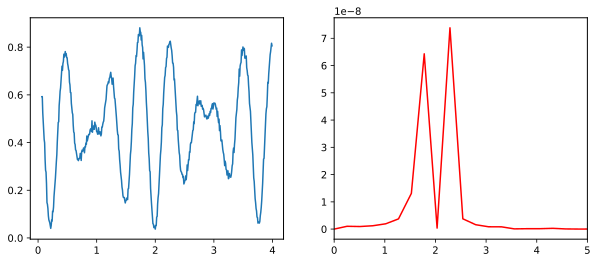

In [109]:
import scipy

fs = 1/(16*dt)
(freq, S) = scipy.signal.periodogram(pop2_ramseyv0, fs, scaling='density')
dominant_freq = freq[np.argmax(S)]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

ax1.plot(delay_time_sec*1e6, pop2_ramseyv0)
ax2.plot(freq/1e6, S, color='red')
ax2.set_xlim([0, 5])
# ax2.set_ylim([1e-10, 1e-7])